In [1]:
import os
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from utils.data_utils import get_dataset, DynamicBatchSampler, collate_fn, get_static_dataset, get_test_dataset, get_grouping, get_test_synthetic_dataset
from utils.optuna_utils import load_best_model
from utils.train_utils import TwoStageQuantileLoss, ComparisonQuantileLoss
from LSTM import train

quantiles = [
        0.00005, 0.00025, 0.00075, 0.00125, 0.00175, 0.0025, 0.005, 0.01, 0.015, 0.02, 0.03,
        0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
        0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99, 0.995, 0.9975, 0.99925, 0.99975, 0.99995
    ]
loss_fn = TwoStageQuantileLoss(quantiles)
test_loss_fn = ComparisonQuantileLoss(quantiles)
results = {}


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
lstm_model, lstm_params = load_best_model('lstm')

lstm_model.to(DEVICE)

lstm_normalazation_window = lstm_params['normalazation_window']
lstm_batch_size = lstm_params['batch_size']
l1_reg = lstm_params['l1_reg']
l2_reg = lstm_params['l2_reg']

lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lstm_params['learning_rate'], weight_decay=l2_reg)

print(lstm_model)
print(f"Model has {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)} parameters")

LSTM_Model(
  (normalize_lstm): LSTM(49, 64, num_layers=2, batch_first=True, dropout=0.23715026182885748)
  (normalize_module): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.23715026182885748, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (5): Dropout(p=0.23715026182885748, inplace=False)
    (6): Linear(in_features=256, out_features=37, bias=True)
  )
  (market_lstm): LSTM(21, 128, num_layers=3, batch_first=True, dropout=0.23715026182885748)
  (market_module): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Dropout(p=0.23715026182885748, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
Model has 489638 parameters


In [3]:
if os.path.exists('lstm_model.pth'):
    lstm_model.load_state_dict(torch.load('lstm_model.pth'))
    lstm_model.to(DEVICE)
    print("Model loaded from lstm_model.pth")
else:
    lstm_train_dataset = get_dataset(
    lstm_normalazation_window, "1998-01-01", "2018-01-01")
    lstm_val_dataset = get_dataset(lstm_normalazation_window, "2018-01-01", "2019-01-01")
    lstm_train_batch_sampler = DynamicBatchSampler(
        lstm_train_dataset, batch_size=lstm_batch_size)
    lstm_val_batch_sampler = DynamicBatchSampler(lstm_val_dataset, batch_size=lstm_batch_size)


    lstm_train_loader = DataLoader(
        lstm_train_dataset, batch_sampler=lstm_train_batch_sampler, collate_fn=collate_fn)
    lstm_val_loader = DataLoader(
        lstm_val_dataset, batch_sampler=lstm_val_batch_sampler, collate_fn=collate_fn)
    _, lstm_model = train(
        model=lstm_model,
        train_loader=lstm_train_loader,
        val_loader=lstm_val_loader,
        criterion=loss_fn,
        optimizer=lstm_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(lstm_model.state_dict(), 'lstm_model.pth')


Model loaded from lstm_model.pth


/tmp/ipykernel_2788/2344815876.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load('lstm_model.pth'))


In [4]:
dense_model, dense_params = load_best_model('dense')

dense_model.to(DEVICE)

dense_normalazation_window = dense_params['normalazation_window']
dense_batch_size = dense_params['batch_size']
l1_reg = dense_params['l1_reg']
l2_reg = dense_params['l2_reg']

dense_optimizer = torch.optim.Adam(dense_model.parameters(), lr=dense_params['learning_rate'], weight_decay=l2_reg)

print(dense_model)

QuantileDense(
  (raw_layers): ModuleList(
    (0): Linear(in_features=49, out_features=256, bias=True)
    (1): Dropout(p=0.029313152060112584, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.029313152060112584, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): Dropout(p=0.029313152060112584, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=64, bias=True)
    (10): Dropout(p=0.029313152060112584, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=512, bias=True)
    (13): Dropout(p=0.029313152060112584, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=37, bias=True)
  )
  (raw_model): Sequential(
    (0): Linear(in_features=49, out_features=256, bias=True)
    (1): Dropout(p=0.029313152060112584, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)

In [5]:
if os.path.exists('dense_model.pth'):
    dense_model.load_state_dict(torch.load('dense_model.pth'))
    dense_model.to(DEVICE)
    print("Model loaded from dense_model.pth")
else:
    dense_train_dataset = get_static_dataset(dense_normalazation_window, "1998-01-01", "2018-01-01")
    dense_val_dataset = get_static_dataset(dense_normalazation_window, "2018-01-01", "2019-01-01")

    dense_train_loader = DataLoader(dense_train_dataset, batch_size=dense_batch_size, shuffle=True)
    dense_val_loader = DataLoader(dense_val_dataset, batch_size=dense_batch_size, shuffle=False)
    _, dense_model = train(
        model=dense_model,
        train_loader=dense_train_loader,
        val_loader=dense_val_loader,
        criterion=loss_fn,
        optimizer=dense_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(dense_model.state_dict(), 'dense_model.pth')

Model loaded from dense_model.pth


/tmp/ipykernel_2788/2142353267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dense_model.load_state_dict(torch.load('dense_model.pth'))


In [6]:
dense_test_dataset = get_test_dataset(dense_normalazation_window, "2019-01-01", "2024-01-01")
lstm_test_dataset = get_test_dataset(lstm_normalazation_window, "2019-01-01", "2024-01-01")

In [7]:
def infrence(model, dataloader, is_dense=True):
    losses = []
    targets = []
    model.eval()
    for x, s, z, y, _ in dataloader:
        x, s, z, y = x.to(DEVICE), s.to(DEVICE), z.to(DEVICE), y.to(DEVICE)
        if is_dense:
            x = x[:, 0, :]
            z = z[:, 0, :]
            s = s[:, 0]
        else:
            s = s.mean(dim=1)
        with torch.no_grad():
            _, y_pred = model(x, s, z)
            loss = test_loss_fn(y_pred, y[:, -1])
            losses.extend(loss.cpu().numpy())
            targets.extend(y[:, -1].cpu().numpy())
    losses = torch.tensor(losses)
    targets = torch.tensor(targets)

    return losses

In [8]:
assets = dense_test_dataset.assets
datas = dense_test_dataset.datas

In [9]:
warnings.filterwarnings("ignore")
batch_size = 1024
for asset in tqdm(assets, desc='Inferencing models'):
    grouping = get_grouping(datas, asset)
    if grouping not in results:
        results[grouping] = {
            'dense': 0,
            'lstm': 0
        }
    dense_test_dataset.set_main_asset(asset)
    lstm_test_dataset.set_main_asset(asset)
    
    dense_data_loader = DataLoader(dense_test_dataset, batch_size=1024, shuffle=False)
    lstm_data_loader = DataLoader(lstm_test_dataset, batch_size=1024, shuffle=False)
    dense_losses = infrence(dense_model, dense_data_loader, is_dense=True)
    lstm_losses = infrence(lstm_model, lstm_data_loader, is_dense=False)
    results[grouping]['dense'] += dense_losses.mean().item()
    results[grouping]['lstm'] += lstm_losses.mean().item()

Inferencing models:   0%|          | 0/60 [00:00<?, ?it/s]

In [10]:
results = {k: {model: value / 10 for model, value in v.items()} for k, v in results.items()}

# Create DataFrame
df = pd.DataFrame(results).T

# Calculate total mean
dense_total_mean = df['dense'].mean()
lstm_total_mean = df['lstm'].mean()
new_row = pd.DataFrame({'dense': dense_total_mean, 'lstm': lstm_total_mean}, index=['Total Mean'])
df = pd.concat([df, new_row])

# Calculate difference
df['Difference (Dense - LSTM)'] = df['dense'] - df['lstm']

# Format the table
formatted_df = df.apply(lambda x: round(x, 4))

print(formatted_df.to_string())

                   dense    lstm  Difference (Dense - LSTM)
commodities       0.5132  0.4921                     0.0211
cryptocurrencies  1.2342  1.2422                    -0.0079
s&p 500           0.4830  0.4648                     0.0182
nikkei 225        0.5050  0.4828                     0.0222
euro stoxx 50     0.5238  0.4912                     0.0325
currency pairs    0.1645  0.1648                    -0.0003
Total Mean        0.5706  0.5563                     0.0143


In [11]:
dense_synthetic_test_dataset, lstm_synthetic_test_dataset = get_test_synthetic_dataset(dense_normalazation_window, lstm_normalazation_window, 1000, 0.7)

Generated mu: -0.000713, sigma: 0.028807
Generated mu: 0.000810, sigma: 0.026998
Generated mu: -0.000253, sigma: 0.024460
Generated mu: 0.000480, sigma: 0.016912
Generated mu: 0.000051, sigma: 0.014252
Generated mu: 0.000549, sigma: 0.019009
Generated mu: 0.000780, sigma: 0.013379
Generated mu: -0.000875, sigma: 0.015398
Generated mu: -0.000199, sigma: 0.027863
Generated mu: 0.000650, sigma: 0.014030
Asset 1 correlation with market data: 0.4847
Asset 2 correlation with market data: 0.4961
Asset 3 correlation with market data: 0.5298
Asset 4 correlation with market data: 0.5108
Asset 5 correlation with market data: 0.4949
Asset 6 correlation with market data: 0.5159
Asset 7 correlation with market data: 0.5056
Asset 8 correlation with market data: 0.4989
Asset 9 correlation with market data: 0.4992
Asset 10 correlation with market data: 0.4996


In [12]:
dense_total_loss = 0
lstm_total_loss = 0
for i in range(0, 10):
    dense_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
    lstm_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
    dense_data_loader = DataLoader(dense_synthetic_test_dataset, batch_size=1024, shuffle=False)
    lstm_data_loader = DataLoader(lstm_synthetic_test_dataset, batch_size=1024, shuffle=False)
    dense_losses = infrence(dense_model, dense_data_loader, is_dense=True)
    lstm_losses = infrence(lstm_model, lstm_data_loader, is_dense=False)
    dense_total_loss += dense_losses.mean().item()
    lstm_total_loss += lstm_losses.mean().item()

dense_total_loss /= 10
lstm_total_loss /= 10

results["synthetic"] = {
    'dense': dense_total_loss,
    'lstm': lstm_total_loss
}

In [13]:
# Create DataFrame
df = pd.DataFrame(results).T

# Calculate total mean
dense_total_mean = df['dense'].mean()
lstm_total_mean = df['lstm'].mean()
new_row = pd.DataFrame({'dense': dense_total_mean, 'lstm': lstm_total_mean}, index=['Total Mean'])
df = pd.concat([df, new_row])

# Calculate difference
df['Difference (Dense - LSTM)'] = df['dense'] - df['lstm']

# Format the table
formatted_df = df.apply(lambda x: round(x, 4))

print(formatted_df.to_string())

                   dense    lstm  Difference (Dense - LSTM)
commodities       0.5132  0.4921                     0.0211
cryptocurrencies  1.2342  1.2422                    -0.0079
s&p 500           0.4830  0.4648                     0.0182
nikkei 225        0.5050  0.4828                     0.0222
euro stoxx 50     0.5238  0.4912                     0.0325
currency pairs    0.1645  0.1648                    -0.0003
synthetic         0.8159  0.5304                     0.2855
Total Mean        0.6057  0.5526                     0.0530


In [14]:
def corr_infrence(model, dataloader):
    model.eval()
    total_loss = 0
    total_corr = 0
    for x, s, z, y, sy in tqdm(dataloader, desc='Inferencing model', leave=False):
        x, s, z, y, sy = x.to(DEVICE), s.to(DEVICE), z.to(DEVICE), y.to(DEVICE), sy.to(DEVICE)
        total_corr += len(x)
        with torch.no_grad():
            _, raw_pred = model(x, s, z)
            loss = test_loss_fn(raw_pred, y[:, -1])
            total_loss += loss.sum().item()
        
    return total_loss/total_corr
        

In [15]:
lookaheads = []
losses = []
for i in tqdm(range(3, 31), desc='Calculating LSTM correlation'):
    lstm_corr_data = get_dataset(lstm_normalazation_window, "2019-01-01", "2024-01-01", i)
    corr_sampler = DynamicBatchSampler(lstm_corr_data, batch_size=batch_size)
    corr_loader = DataLoader(lstm_corr_data, batch_sampler=corr_sampler, collate_fn=collate_fn)
    loss = corr_infrence(lstm_model, corr_loader)
    lookaheads.append(i)
    losses.append(loss)
    

Calculating LSTM correlation:   0%|          | 0/28 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/24 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/19 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/17 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/16 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/15 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/15 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/15 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/14 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/14 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/14 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/14 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/13 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/13 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/10 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/12 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/8 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/10 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/10 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/9 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/11 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/8 [00:00<?, ?it/s]

Inferencing model:   0%|          | 0/10 [00:00<?, ?it/s]

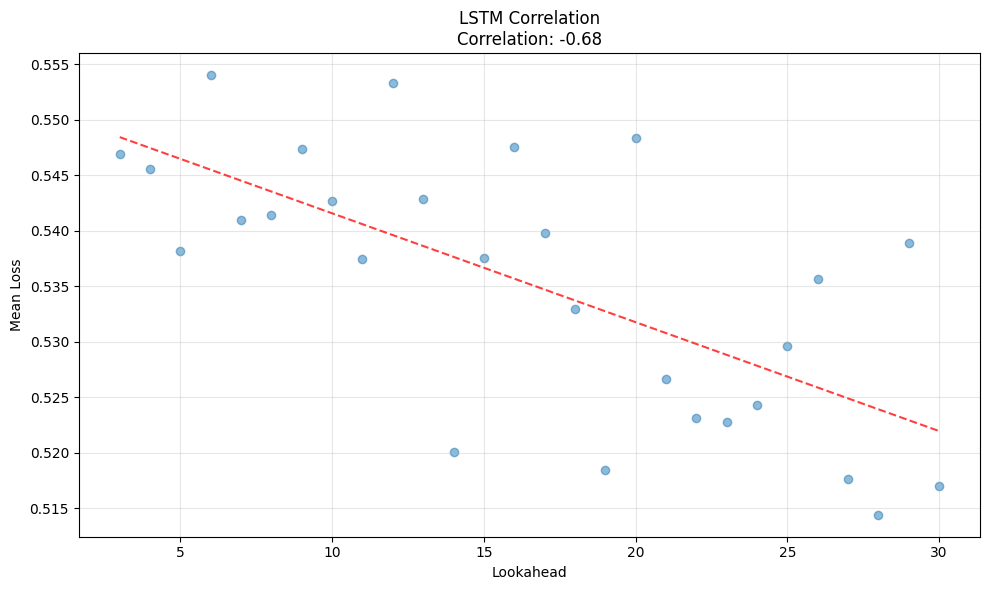

In [16]:
x = np.array(lookaheads)
y = np.array(losses)

xlabel = "Lookahead"
ylabel = "Mean Loss"

title = "LSTM Correlation"

# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title(f"{title}\nCorrelation: {correlation:.2f}")
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# Add correlation line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", alpha=0.75)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()